## Gaussian Mixture Models


- <i>Elements of Statistical Learning</i> by Hastie et al. (2009)
 - [Section 6.8 - Mixture Models for Density Estimation and Classification](#Section-6.8---Mixture-Models-for-Density-Estimation-and-Classification)
 - [Section 8.5.1 - Two-Component Mixture Model](#Section-8.5.1---Two-Component-Mixture-Model)


- <i>Pattern Recognition and Machine Learning</i> by Bishop (2006)
 - [Section 2.3.9 - Mixtures of Gaussians](#Section-2.3.9---Mixtures-of-Gaussians)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import scipy as spy
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.mixture import GMM

from matplotlib.colors import LogNorm

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
pd.set_option('expand_frame_repr', True)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

### Examples from <i>Elements of Statistical Learning</i> by Hastie et al. (2009)
#### Section 6.8 - Mixture Models for Density Estimation and Classification

In [2]:
data = pd.read_csv('data/SAheart.data', sep=',', decimal='.', usecols=np.arange(1,11))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
sbp          462 non-null int64
tobacco      462 non-null float64
ldl          462 non-null float64
adiposity    462 non-null float64
famhist      462 non-null object
typea        462 non-null int64
obesity      462 non-null float64
alcohol      462 non-null float64
age          462 non-null int64
chd          462 non-null int64
dtypes: float64(5), int64(4), object(1)
memory usage: 34.3+ KB


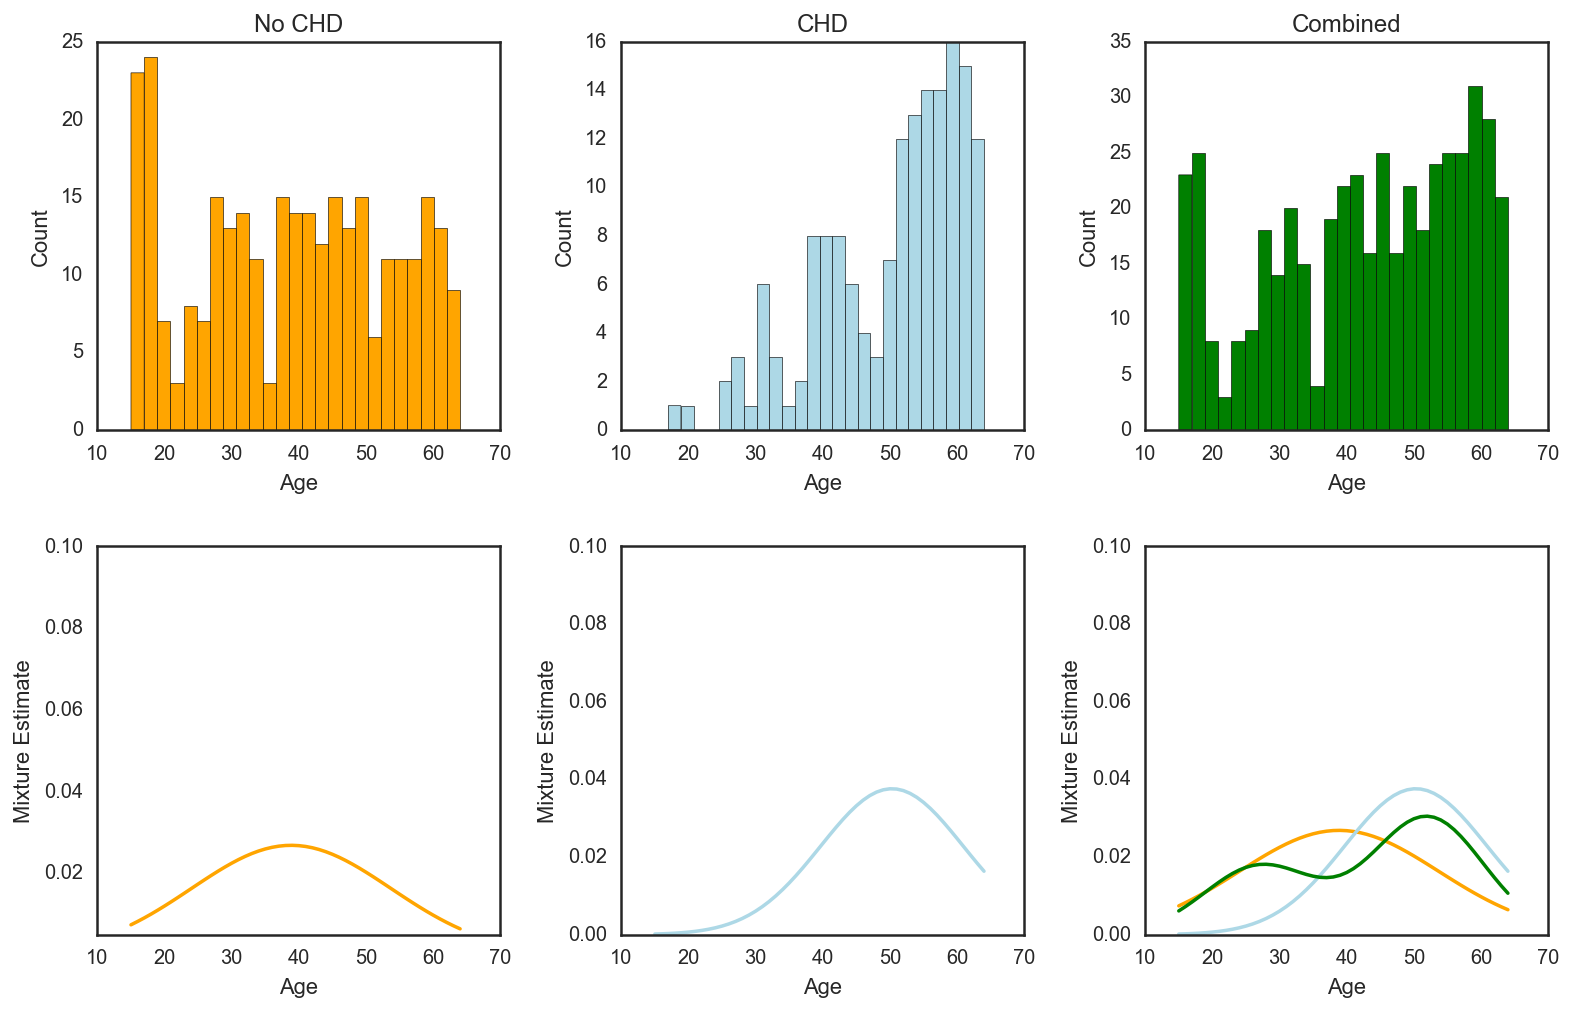

In [3]:
mixm = GMM(n_components=1, covariance_type='tied')
x = np.linspace(data.age.min(), data.age.max()).reshape(-1,1)

mixm.fit(data[data['chd'] == 0]['age'].reshape(-1,1))
no_chd = np.exp(mixm.score(x))

mixm.fit(data[data['chd'] == 1]['age'].reshape(-1,1))
chd = np.exp(mixm.score(x))

mixm.set_params(n_components=2)
mixm.fit(data['age'].reshape(-1,1))
combined = np.exp(mixm.score(x))

# Create Plots
fig, ax = plt.subplots(2,3, figsize=(13,8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Plots on first row
ax[0,0].hist(data[data.chd == 0]['age'].values, bins=25, color='orange')
ax[0,0].set_title('No CHD')

ax[0,1].hist(data[data.chd == 1]['age'].values, bins=25, color='lightblue')
ax[0,1].set_title('CHD')

ax[0,2].hist(data.age.values, bins=25, color='g')
ax[0,2].set_title('Combined')

for i in ax[0]:
    i.set_xlabel('Age')
    i.set_ylabel('Count')

# Plots on second row
ax[1,0].plot(x, no_chd, c='orange')

ax[1,1].plot(x, chd, c='lightblue')

ax[1,2].plot(x, no_chd, c='orange')
ax[1,2].plot(x, chd, c='lightblue')
ax[1,2].plot(x, combined , c='green')

for i in ax[1]:
    i.set_ylim(ymax = 0.10)
    i.set_xlabel('Age')
    i.set_ylabel('Mixture Estimate')

#### Section 8.5.1 - Two-Component Mixture Model

In [4]:
y = np.array([-0.39, 0.12, 0.94, 1.67, 1.76, 2.44, 3.72, 4.28, 4.92, 5.53,
             0.06, 0.48, 1.01, 1.68, 1.80, 3.25, 4.12, 4.60, 5.28, 6.22]).reshape(-1,1)
mixm = GMM(n_components=2, random_state=1, verbose=1)
mixm.fit(y)

Expectation-maximization algorithm started.
Initialization 1
	EM iteration 1
	EM iteration 2
	EM iteration 3
	EM iteration 4
	EM iteration 5
	EM iteration 6
	EM iteration 7
	EM iteration 8
	EM iteration 9
		EM algorithm converged.


GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=1,
  thresh=None, tol=0.001, verbose=1)

In [5]:
mixm.means_

array([[ 1.05928087],
       [ 4.62201285]])

In [6]:
mixm.covars_

array([[ 0.77854847],
       [ 0.87684948]])

In [7]:
mixm.weights_

array([ 0.54663468,  0.45336532])

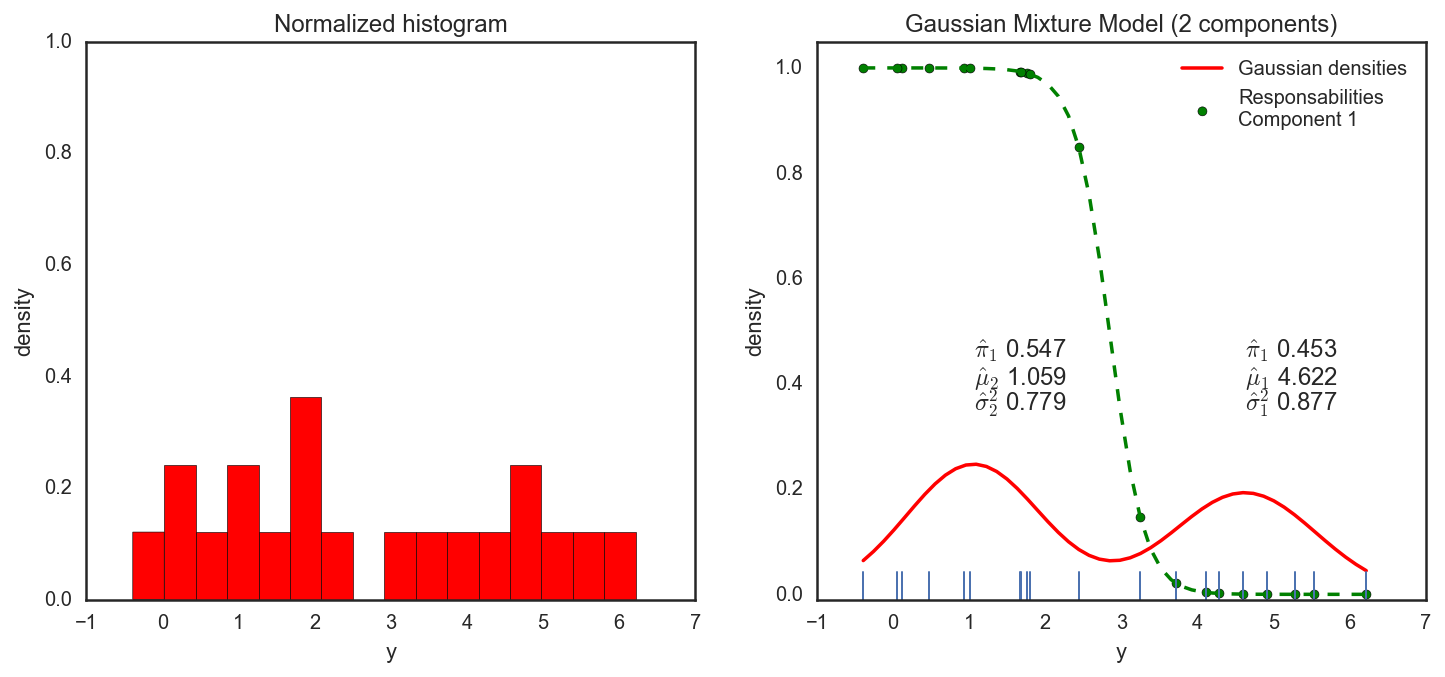

In [8]:
y_ = np.linspace(y.min(), y.max()).reshape(-1,1)
y_density = np.exp(mixm.score(y_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# left plot
ax1.hist(y, bins=16, normed=True, color='r')
ax1.set_ylim((0,1))
ax1.set_title('Normalized histogram')

# right plot
ax2.plot(y_, y_density, color='r', label='Gaussian densities')
ax2.scatter(y, mixm.score_samples(y)[1][:,0], c='g', label='Responsabilities\nComponent 1')
ax2.plot(y_, mixm.score_samples(y_)[1][:,0], '--g' )
sns.distplot(y, hist=False, kde=False, rug=True, ax=ax2)
ax2.set_ylim((-0.01,1.05))
ax2.set_title('Gaussian Mixture Model (2 components)')
ax2.legend()
ax2.text(mixm.means_[1],0.45 , '$\^\pi_1$ {}'.format(np.round(mixm.weights_[1], 3)))
ax2.text(mixm.means_[1],0.4 , '$\^\mu_1$ {}'.format(np.round(mixm.means_[1,0], 3)))
ax2.text(mixm.means_[1],0.35 , '$\^\sigma_1^2$ {}'.format(np.round(mixm.covars_[1,0], 3)))

ax2.text(mixm.means_[0],0.45 , '$\^\\pi_1$ {}'.format(np.round(mixm.weights_[0], 3)))
ax2.text(mixm.means_[0],0.4 , '$\^\mu_2$ {}'.format(np.round(mixm.means_[0,0], 3)))
ax2.text(mixm.means_[0],0.35 , '$\^\sigma_2^2$ {}'.format(np.round(mixm.covars_[0,0], 3)))

for i in fig.axes:
    i.set_xlabel('y')
    i.set_ylabel('density')

### Example from <i>Pattern Recognition and Machine Learning</i> by Bishop (2006)
#### Section 2.3.9 - Mixtures of Gaussians

In [9]:
faithful = pd.read_csv('data/faithful.csv')
faithful.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 2 columns):
eruptions    272 non-null float64
waiting      272 non-null int64
dtypes: float64(1), int64(1)
memory usage: 4.3 KB


In [10]:
mixm2 = GMM(n_components=2, covariance_type='full')
mixm2.fit(faithful)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

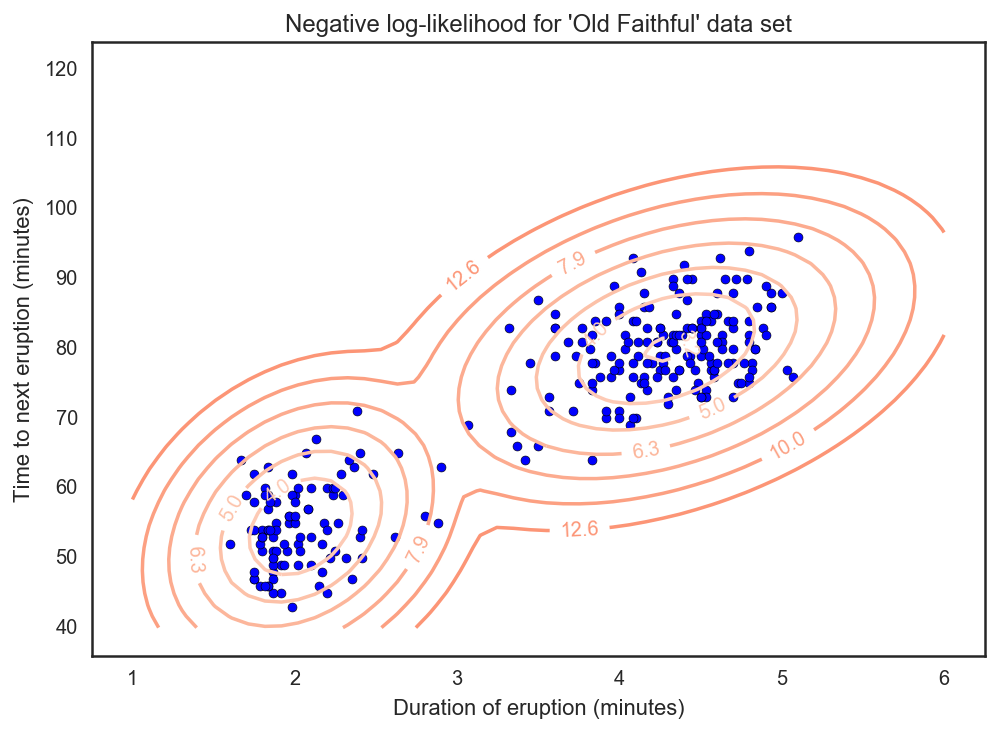

In [11]:
x = np.linspace(1, 6)
y = np.linspace(40, 120)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# Z represents log probabilities of XX under mixm2 model
Z = -mixm2.score(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 1.1, 12), cmap=plt.cm.Reds)
plt.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

plt.scatter(faithful.eruptions, faithful.waiting)
plt.xlabel('Duration of eruption (minutes)')
plt.ylabel('Time to next eruption (minutes)')
plt.title("Negative log-likelihood for 'Old Faithful' data set");